# Датасет

In [36]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.metrics import jaccard_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms

from sklearn.model_selection import ParameterGrid

In [37]:
@dataclass
class Config:
    image_size = (128, 128)
    batch_size = 32
    epochs = 15
    learning_rate = 0.0001
    device = "cuda" if torch.cuda.is_available() else "cpu"
    train_split = 0.8

config = Config()

In [38]:
class PetDataset(Dataset):
    def __init__(self, root, split='trainval', transform=None):
        self.root = root
        self.transform = transform
        self.dataset = torchvision.datasets.OxfordIIITPet(root=root, split=split, target_types='segmentation', download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]

        mask = np.array(mask)
        mask = (mask > 1).astype(np.uint8)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)

        mask = mask.resize((128, 128))
        mask = F.pil_to_tensor(mask).float()

        return image, mask

# U-Net

In [39]:
class EncBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncBlock, self).__init__()

        self.encblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encblock(x)

# decoder
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.enc0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding = 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.enc = EncBlock(in_channels, out_channels)

    def forward(self, x, e):
        x = self.enc0(x) #up-conv
        x = torch.cat([x, e], 1)
        x = self.enc(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # тут слои обозначить для encoder, bottleneck и decoder
        # encoder
        self.enc1 = EncBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = EncBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = EncBlock(128,256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = EncBlock(256,512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # bottleneck
        self.bottleneck = EncBlock(512, 1024)
        # decoder + MaxUnpool2d to reverse the effect of MaxPool2d (needs indices)
        self.dec1 = Decoder(1024, 512)
        self.dec2 = Decoder(512, 256)
        self.dec3 = Decoder(256, 128)
        self.dec4 = Decoder(128, 64)
        #  end
        self.convend = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e1 = self.enc1(x) #skipconn
        p1 = self.pool1(e1)
        e2 = self.enc2(p1) #skipconn
        p2 = self.pool2(e2)
        e3 = self.enc3(p2) #skipconn
        p3 = self.pool3(e3)
        e4 = self.enc4(p3) #skipconn
        p4 = self.pool4(e4)

        # bottleneck
        b = self.bottleneck(p4)

        # decoder
        d1 = self.dec1(b, e4)
        d2 = self.dec2(d1, e3)
        d3 = self.dec3(d2, e2)
        d4 = self.dec4(d3, e1)
        x = self.convend(d4)

        return x

In [44]:
import time
import torch

class Trainer:
    def __init__(self, config):
        self.config = config

        self.transform = transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.model = UNet().to(config.device)
        # какой лосс удобный возьмем для бинарной сегментации?
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]).to(config.device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)

        self.setup_dataloader()

        # Сравнение моделей
        self.train_losses = []
        self.val_losses = []
        self.val_ious = []
        self.val_f1s = []

        # память + время
        self.epoch_times = []
        self.epoch_max_memory = []

    def setup_dataloader(self):
        dataset = PetDataset(root="./data", split='trainval', transform=self.transform)
        train_size = int(self.config.train_split * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        self.test_dataset = PetDataset(root="./data", split='test', transform=self.transform)

        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.config.batch_size, shuffle=False)

    def run(self):
        for epoch in range(self.config.epochs):
            # память + время
            start_time = time.time()
            if self.config.device.startswith("cuda"):
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()

            train_loss = self.train()
            val_loss, val_iou, val_f1 = self.validate()

            # Сохранение метрик
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_ious.append(val_iou)
            self.val_f1s.append(val_f1)

            epoch_time = time.time() - start_time
            self.epoch_times.append(epoch_time)

            if self.config.device.startswith("cuda"):
                max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2)  # в МБ
            else:
                max_mem = 0
            self.epoch_max_memory.append(max_mem)

            print(f"Epoch {epoch+1} / {self.config.epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val IoU: {val_iou:.4f}, "
                  f"Val F1-score: {val_f1:.4f}, "
                  f"Time: {epoch_time:.1f}, "
                  f"Max GPU Mem: {max_mem:.1f} MB")

        print('Testing...')
        test_loss, test_iou, test_f1 = self.test()

        print(f"Test Loss: {test_loss:.4f}, "
              f"Test IoU: {test_iou:.4f}, "
              f"Test F1-score: {test_f1:.4f}")
        print(f"Average epoch time: {np.mean(self.epoch_times):.1f}s")
        if self.config.device.startswith("cuda"):
            print(f"Average max GPU memory per epoch: {np.mean(self.epoch_max_memory):.1f} MB")


    def train(self):
        self.model.train()
        epoch_loss = 0

        for images, masks in tqdm(self.train_dataloader):
            images = images.to(self.config.device)
            masks = masks.to(self.config.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, masks)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()

        return epoch_loss / len(self.train_dataloader)

    def validate(self):
        self.model.eval()
        val_loss = 0
        iou_scores, f1_scores = [], []

        with torch.no_grad():
            for images, masks in tqdm(self.val_dataloader):
                images = images.to(self.config.device)
                masks = masks.to(self.config.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                val_loss += loss.item()

                pred_masks = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(np.uint8)
                masks = masks.squeeze(1).cpu().numpy().astype(np.uint8)

                for i in range(len(pred_masks)):
                    iou_scores.append(jaccard_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))
                    f1_scores.append(f1_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))

        return val_loss / len(self.val_dataloader), np.mean(iou_scores), np.mean(f1_scores)

    def test(self):
        self.model.eval()
        test_loss = 0
        iou_scores, f1_scores = [], []

        with torch.no_grad():
            for images, masks in tqdm(self.test_dataloader):
                images = images.to(self.config.device)
                masks = masks.to(self.config.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                test_loss += loss.item()

                pred_masks = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(np.uint8)
                masks = masks.squeeze(1).cpu().numpy().astype(np.uint8)

                for i in range(len(pred_masks)):
                    iou_scores.append(jaccard_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))
                    f1_scores.append(f1_score(masks[i].flatten(), pred_masks[i].flatten(), average='binary'))

        return test_loss / len(self.test_dataloader), np.mean(iou_scores), np.mean(f1_scores)

    def inference_and_plot_samples(self, n_samples=3):
        self.model.eval()

        with torch.no_grad():
            fig, axes = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))

            for i in range(n_samples):
                img, mask = self.test_dataset[i]
                img_tensor = img.unsqueeze(0).to(self.config.device)

                output = self.model(img_tensor)
                output = torch.sigmoid(output).squeeze().cpu().numpy()
                output = (output >= 0.5).astype('float')

                axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
                axes[i, 0].set_title("Image")
                axes[i, 1].imshow(mask.squeeze().cpu(), cmap="gray")
                axes[i, 1].set_title("Ground Truth")
                axes[i, 2].imshow(output, cmap="gray")
                axes[i, 2].set_title("Predicted Mask")

            plt.show()


In [45]:
trainer = Trainer(config)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [46]:
trainer.run()

100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


Epoch 1 / 15, Train Loss: 1.3154, Val Loss: 1.3496, Val IoU: 0.7723, Val F1-score: 0.8655, Time: 68.0, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 2 / 15, Train Loss: 1.1632, Val Loss: 1.3068, Val IoU: 0.7867, Val F1-score: 0.8749, Time: 67.4, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:10<00:00,  2.10it/s]


Epoch 3 / 15, Train Loss: 1.1195, Val Loss: 1.1335, Val IoU: 0.8440, Val F1-score: 0.9106, Time: 66.4, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 4 / 15, Train Loss: 1.0863, Val Loss: 1.0928, Val IoU: 0.8551, Val F1-score: 0.9176, Time: 66.8, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 5 / 15, Train Loss: 1.0521, Val Loss: 1.0939, Val IoU: 0.8480, Val F1-score: 0.9130, Time: 66.8, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


Epoch 6 / 15, Train Loss: 1.0324, Val Loss: 1.0644, Val IoU: 0.8668, Val F1-score: 0.9248, Time: 66.4, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 7 / 15, Train Loss: 1.0048, Val Loss: 1.0744, Val IoU: 0.8509, Val F1-score: 0.9142, Time: 66.8, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.07it/s]


Epoch 8 / 15, Train Loss: 0.9860, Val Loss: 1.0177, Val IoU: 0.8651, Val F1-score: 0.9235, Time: 66.4, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.02it/s]


Epoch 9 / 15, Train Loss: 0.9566, Val Loss: 1.1022, Val IoU: 0.8523, Val F1-score: 0.9146, Time: 66.8, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.04it/s]


Epoch 10 / 15, Train Loss: 0.9389, Val Loss: 1.0280, Val IoU: 0.8712, Val F1-score: 0.9269, Time: 66.9, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.03it/s]


Epoch 11 / 15, Train Loss: 0.9278, Val Loss: 1.0928, Val IoU: 0.8467, Val F1-score: 0.9116, Time: 66.7, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.08it/s]


Epoch 12 / 15, Train Loss: 0.9197, Val Loss: 1.0890, Val IoU: 0.8526, Val F1-score: 0.9153, Time: 66.5, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.04it/s]


Epoch 13 / 15, Train Loss: 0.8980, Val Loss: 0.9745, Val IoU: 0.8775, Val F1-score: 0.9303, Time: 66.7, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.05it/s]


Epoch 14 / 15, Train Loss: 0.8828, Val Loss: 0.9691, Val IoU: 0.8807, Val F1-score: 0.9331, Time: 66.9, Max GPU Mem: 4344.4 MB


100%|██████████| 23/23 [00:11<00:00,  2.02it/s]


Epoch 15 / 15, Train Loss: 0.8634, Val Loss: 0.9702, Val IoU: 0.8884, Val F1-score: 0.9375, Time: 67.0, Max GPU Mem: 4344.4 MB
Testing...


100%|██████████| 115/115 [00:57<00:00,  2.00it/s]

Test Loss: 0.9702, Test IoU: 0.8859, Test F1-score: 0.9353
Average epoch time: 66.8s
Average max GPU memory per epoch: 4344.4 MB


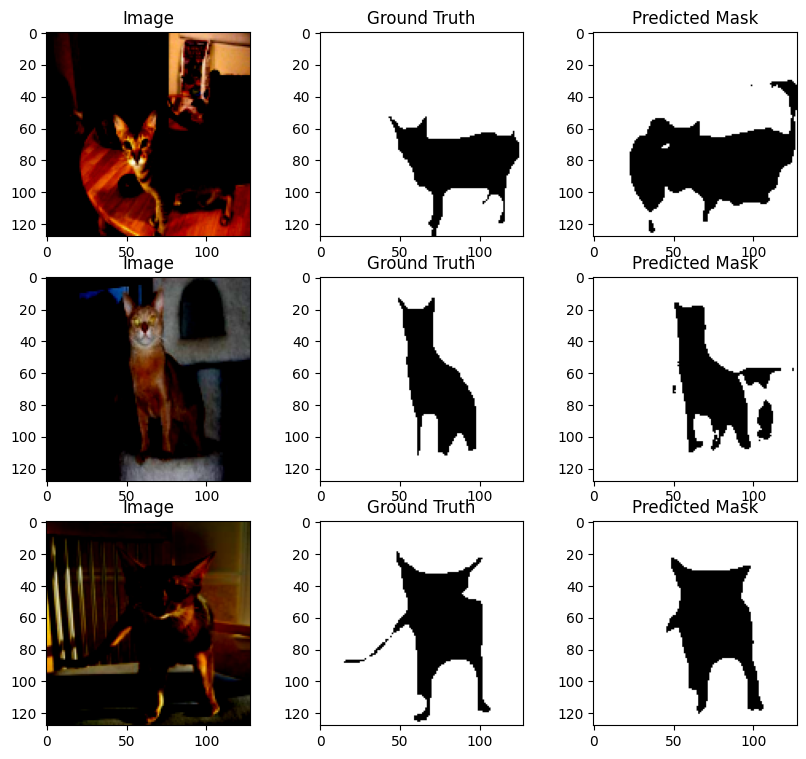

In [47]:
trainer.inference_and_plot_samples(n_samples=3)

In [48]:
train_losses = trainer.train_losses
val_losses = trainer.val_losses
val_ious = trainer.val_ious
val_f1s = trainer.val_f1s

In [49]:
print(train_losses)
print(val_losses)
print(val_ious)
print(val_f1s)

[1.3153953357883121, 1.1631855057633442, 1.1194631820139678, 1.0863397769306018, 1.0520587369151737, 1.0323786690183308, 1.0048344316689863, 0.9859721978073535, 0.956584720507912, 0.9389288555020872, 0.9278312046890673, 0.9196767418280892, 0.8980286419391632, 0.8828088602294093, 0.8634367338989092]
[1.3495818169220635, 1.3067931144133857, 1.1335315186044443, 1.092767886493517, 1.0938638759695964, 1.0643701812495356, 1.0743981910788494, 1.0177337760510652, 1.102166113646134, 1.028047193651614, 1.0927865090577498, 1.089017453400985, 0.9745339336602584, 0.9691175351972166, 0.9702120215996451]
[np.float64(0.7723247754217518), np.float64(0.7867407172080242), np.float64(0.84396258509412), np.float64(0.8551009607649279), np.float64(0.8479514307497327), np.float64(0.8667984976763495), np.float64(0.85089864556317), np.float64(0.8650942444157664), np.float64(0.8523180789026881), np.float64(0.8712498289534519), np.float64(0.8467187721811602), np.float64(0.8525796906907399), np.float64(0.877473210

In [50]:
times = trainer.epoch_times
max_memory = trainer.epoch_max_memory

In [51]:
print(times)
print(max_memory)

[67.96162152290344, 67.41015601158142, 66.35453772544861, 66.80785202980042, 66.79725956916809, 66.40121912956238, 66.8179304599762, 66.38160419464111, 66.80070972442627, 66.93595790863037, 66.73826718330383, 66.49907779693604, 66.67379331588745, 66.89118766784668, 66.97438621520996]
[4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625, 4344.3994140625]


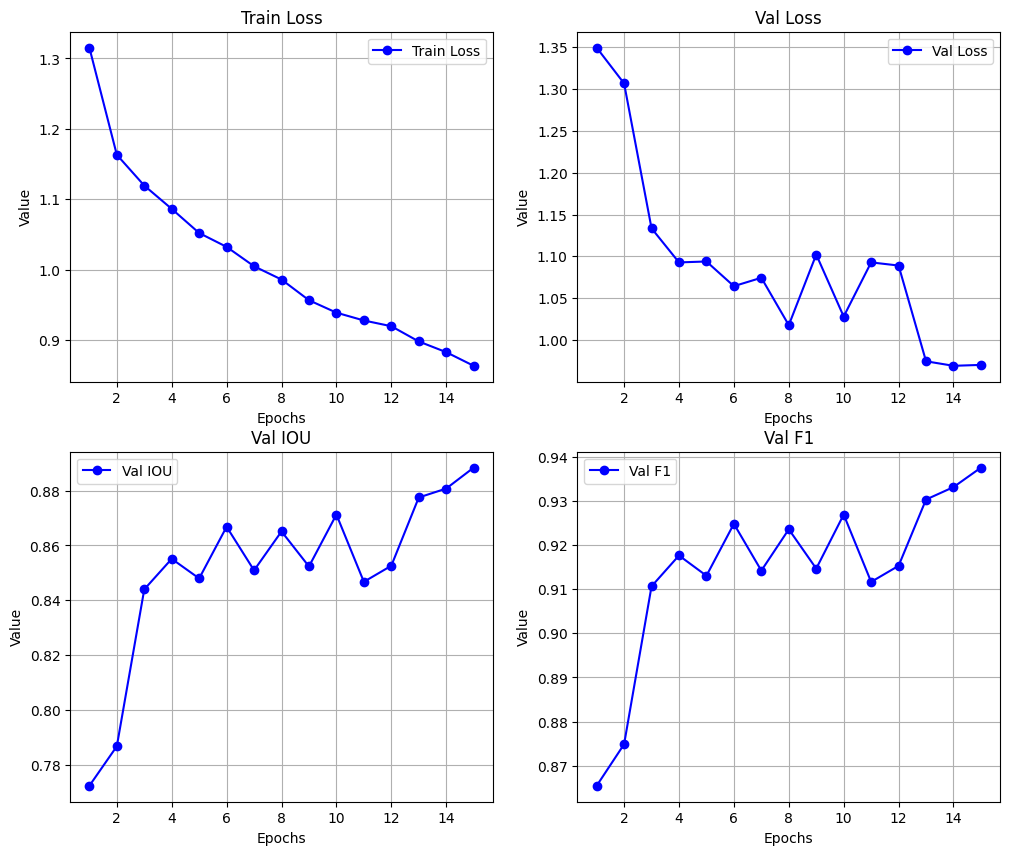

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
axs[0, 0].set_title('Train Loss')

axs[0, 1].plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss', color='blue', marker='o')
axs[0, 1].set_title('Val Loss')

axs[1, 0].plot(range(1, len(val_ious) + 1), val_ious, label='Val IOU', color='blue', marker='o')
axs[1, 0].set_title('Val IOU')

axs[1, 1].plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1', color='blue', marker='o')
axs[1, 1].set_title('Val F1')


for i in range(2):
  for j in range(2):
    axs[i, j].set_xlabel('Epochs')
    axs[i, j].set_ylabel('Value')
    axs[i, j].legend()
    axs[i, j].grid()


# Трансформер

In [56]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

In [66]:
class Trainer:
    def __init__(self, config):
        self.config = config

        # Трансформ для изображений (маски обрабатываем отдельно)
        self.transform = transforms.Compose([
            transforms.Resize(config.image_size),
            transforms.ToTensor()
        ])

        # Инициализация SegFormer с 2 классами (фон и объект)
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            num_labels=2,
            ignore_mismatched_sizes=True
        ).to(config.device)

        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=config.learning_rate)

        self.setup_dataloader()

        self.train_losses = []
        self.val_losses = []
        self.val_ious = []
        self.val_f1s = []

        self.epoch_times = []
        self.epoch_max_memory = []

        # Процессор для подготовки батчей (изображения + маски)
        self.processor = SegformerImageProcessor(
            size={"height": config.image_size[0], "width": config.image_size[1]},
            do_reduce_labels=False
        )

    def setup_dataloader(self):
        dataset = PetDataset(root="./data", split='trainval', transform=self.transform)
        train_size = int(self.config.train_split * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        self.test_dataset = PetDataset(root="./data", split='test', transform=self.transform)

        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True, collate_fn=self.collate_fn)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False, collate_fn=self.collate_fn)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.config.batch_size, shuffle=False, collate_fn=self.collate_fn)

    def collate_fn(self, batch):
        images, masks = zip(*batch)
        images = list(images)
        masks = [mask.squeeze(0).long() for mask in masks]  # (H, W)
        processed = self.processor(images=images, segmentation_maps=masks, return_tensors="pt")
        return processed["pixel_values"], processed["labels"]

    def run(self):
        for epoch in range(self.config.epochs):
            start_time = time.time()
            if self.config.device.startswith("cuda"):
                torch.cuda.empty_cache()
                torch.cuda.reset_peak_memory_stats()

            train_loss = self.train()
            val_loss, val_iou, val_f1 = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_ious.append(val_iou)
            self.val_f1s.append(val_f1)

            epoch_time = time.time() - start_time
            self.epoch_times.append(epoch_time)

            if self.config.device.startswith("cuda"):
                max_mem = torch.cuda.max_memory_allocated() / (1024 ** 2)
            else:
                max_mem = 0
            self.epoch_max_memory.append(max_mem)

            print(f"Epoch {epoch+1} / {self.config.epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Val IoU: {val_iou:.4f}, "
                  f"Val F1-score: {val_f1:.4f}, "
                  f"Time: {epoch_time:.1f}s, "
                  f"Max GPU Mem: {max_mem:.1f} MB")

        print('Testing...')
        test_loss, test_iou, test_f1 = self.test()
        print(f"Test Loss: {test_loss:.4f}, "
              f"Test IoU: {test_iou:.4f}, "
              f"Test F1-score: {test_f1:.4f}")
        print(f"Average epoch time: {np.mean(self.epoch_times):.1f}s")
        if self.config.device.startswith("cuda"):
            print(f"Average max GPU memory per epoch: {np.mean(self.epoch_max_memory):.1f} MB")

    def train(self):
        self.model.train()
        epoch_loss = 0
        for pixel_values, labels in tqdm(self.train_dataloader):
            pixel_values = pixel_values.to(self.config.device)
            labels = labels.to(self.config.device)

            self.optimizer.zero_grad()
            outputs = self.model(pixel_values=pixel_values)
            logits = outputs.logits

            # Интерполируем маски до размера выхода модели
            labels_resized = torch.nn.functional.interpolate(
                labels.unsqueeze(1).float(), size=logits.shape[-2:], mode='nearest'
            ).squeeze(1).long()

            loss = self.criterion(logits, labels_resized)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
        return epoch_loss / len(self.train_dataloader)

    def validate(self):
        self.model.eval()
        val_loss = 0
        iou_scores, f1_scores = [], []
        with torch.no_grad():
            for pixel_values, labels in tqdm(self.val_dataloader):
                pixel_values = pixel_values.to(self.config.device)
                labels = labels.to(self.config.device)

                outputs = self.model(pixel_values=pixel_values)
                logits = outputs.logits

                # Интерполируем маски до размера выхода модели
                labels_resized = torch.nn.functional.interpolate(
                    labels.unsqueeze(1).float(), size=logits.shape[-2:], mode='nearest'
                ).squeeze(1).long()

                loss = self.criterion(logits, labels_resized)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                preds = preds.cpu().numpy()
                labels_np = labels_resized.cpu().numpy()

                for pred_mask, true_mask in zip(preds, labels_np):
                    mask = true_mask != 255
                    if mask.sum() == 0:
                        continue
                    iou = jaccard_score(true_mask[mask].flatten(), pred_mask[mask].flatten(), average='binary')
                    f1 = f1_score(true_mask[mask].flatten(), pred_mask[mask].flatten(), average='binary')
                    iou_scores.append(iou)
                    f1_scores.append(f1)

        return val_loss / len(self.val_dataloader), np.mean(iou_scores), np.mean(f1_scores)

    def test(self):
        self.model.eval()
        test_loss = 0
        iou_scores, f1_scores = [], []
        with torch.no_grad():
            for pixel_values, labels in tqdm(self.test_dataloader):
                pixel_values = pixel_values.to(self.config.device)
                labels = labels.to(self.config.device)

                outputs = self.model(pixel_values=pixel_values)
                logits = outputs.logits

                # Интерполируем маски до размера выхода модели
                labels_resized = torch.nn.functional.interpolate(
                    labels.unsqueeze(1).float(), size=logits.shape[-2:], mode='nearest'
                ).squeeze(1).long()

                loss = self.criterion(logits, labels_resized)
                test_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                preds = preds.cpu().numpy()
                labels_np = labels_resized.cpu().numpy()

                for pred_mask, true_mask in zip(preds, labels_np):
                    mask = true_mask != 255
                    if mask.sum() == 0:
                        continue
                    iou = jaccard_score(true_mask[mask].flatten(), pred_mask[mask].flatten(), average='binary')
                    f1 = f1_score(true_mask[mask].flatten(), pred_mask[mask].flatten(), average='binary')
                    iou_scores.append(iou)
                    f1_scores.append(f1)

        return test_loss / len(self.test_dataloader), np.mean(iou_scores), np.mean(f1_scores)


    def inference_and_plot_samples(self, n_samples=3):
        self.model.eval()

        with torch.no_grad():
            fig, axes = plt.subplots(n_samples, 3, figsize=(10, 3 * n_samples))

            for i in range(n_samples):
                img, mask = self.test_dataset[i]
                img_tensor = img.unsqueeze(0).to(self.config.device)

                output = self.model(img_tensor)
                output = torch.sigmoid(output).squeeze().cpu().numpy()
                output = (output >= 0.5).astype('float')

                axes[i, 0].imshow(img.permute(1, 2, 0).cpu())
                axes[i, 0].set_title("Image")
                axes[i, 1].imshow(mask.squeeze().cpu(), cmap="gray")
                axes[i, 1].set_title("Ground Truth")
                axes[i, 2].imshow(output, cmap="gray")
                axes[i, 2].set_title("Predicted Mask")

            plt.show()


In [67]:
trainerSegformer = Trainer(config)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
trainerSegformer.run()

100%|██████████| 92/92 [00:08<00:00, 10.38it/s]


Epoch 1 / 15, Train Loss: 0.4833, Val Loss: 0.4594, Val IoU: 0.7408, Val F1-score: 0.8462, Time: 44.7s, Max GPU Mem: 1104.6 MB


100%|██████████| 92/92 [00:08<00:00, 10.23it/s]


Epoch 2 / 15, Train Loss: 0.4612, Val Loss: 0.4141, Val IoU: 0.7605, Val F1-score: 0.8595, Time: 46.0s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.87it/s]


Epoch 3 / 15, Train Loss: 0.3736, Val Loss: 0.3289, Val IoU: 0.7996, Val F1-score: 0.8835, Time: 45.7s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.80it/s]


Epoch 4 / 15, Train Loss: 0.3043, Val Loss: 0.2688, Val IoU: 0.8434, Val F1-score: 0.9114, Time: 46.1s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.91it/s]


Epoch 5 / 15, Train Loss: 0.2535, Val Loss: 0.2450, Val IoU: 0.8535, Val F1-score: 0.9175, Time: 45.8s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


Epoch 6 / 15, Train Loss: 0.2272, Val Loss: 0.2208, Val IoU: 0.8696, Val F1-score: 0.9269, Time: 44.5s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.86it/s]


Epoch 7 / 15, Train Loss: 0.2095, Val Loss: 0.2017, Val IoU: 0.8817, Val F1-score: 0.9348, Time: 45.9s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.96it/s]


Epoch 8 / 15, Train Loss: 0.1881, Val Loss: 0.1977, Val IoU: 0.8854, Val F1-score: 0.9368, Time: 44.9s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.95it/s]


Epoch 9 / 15, Train Loss: 0.1803, Val Loss: 0.1940, Val IoU: 0.8866, Val F1-score: 0.9371, Time: 45.2s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:08<00:00, 10.31it/s]


Epoch 10 / 15, Train Loss: 0.1690, Val Loss: 0.1889, Val IoU: 0.8885, Val F1-score: 0.9385, Time: 44.0s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00, 10.08it/s]


Epoch 11 / 15, Train Loss: 0.1595, Val Loss: 0.1825, Val IoU: 0.8949, Val F1-score: 0.9424, Time: 44.8s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.87it/s]


Epoch 12 / 15, Train Loss: 0.1558, Val Loss: 0.1964, Val IoU: 0.8858, Val F1-score: 0.9367, Time: 46.1s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:08<00:00, 10.74it/s]


Epoch 13 / 15, Train Loss: 0.1489, Val Loss: 0.1865, Val IoU: 0.8922, Val F1-score: 0.9408, Time: 44.5s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.86it/s]


Epoch 14 / 15, Train Loss: 0.1407, Val Loss: 0.1883, Val IoU: 0.8958, Val F1-score: 0.9430, Time: 44.7s, Max GPU Mem: 1104.2 MB


100%|██████████| 92/92 [00:09<00:00,  9.95it/s]


Epoch 15 / 15, Train Loss: 0.1430, Val Loss: 0.1915, Val IoU: 0.8927, Val F1-score: 0.9410, Time: 44.9s, Max GPU Mem: 1104.2 MB
Testing...


100%|██████████| 459/459 [00:47<00:00,  9.76it/s]

Test Loss: 0.1973, Test IoU: 0.8857, Test F1-score: 0.9356
Average epoch time: 45.2s
Average max GPU memory per epoch: 1104.2 MB


In [70]:
# trainerSegformer.inference_and_plot_samples(n_samples=3)

# Вывод

In [71]:
times = trainer.epoch_times
max_memory = trainer.epoch_max_memory

In [72]:
times_Segformer = trainerSegformer.epoch_times
max_memory_Segformer = trainerSegformer.epoch_max_memory

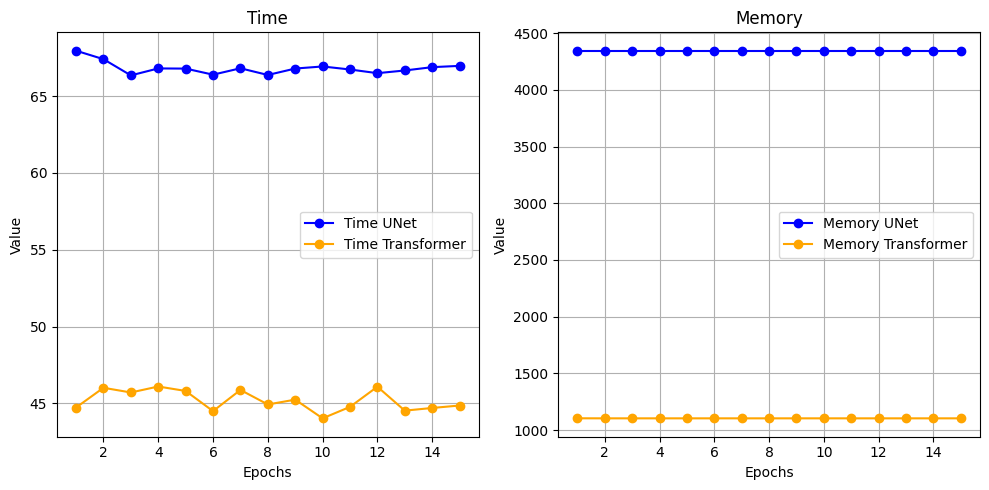

In [78]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# График времени
axs[0].plot(range(1, len(times) + 1), times, label='Time UNet', color='blue', marker='o')
axs[0].plot(range(1, len(times_Segformer) + 1), times_Segformer, label='Time Transformer', color='orange', marker='o')
axs[0].set_title('Time')

# График памяти
axs[1].plot(range(1, len(max_memory) + 1), max_memory, label='Memory UNet', color='blue', marker='o')
axs[1].plot(range(1, len(max_memory_Segformer) + 1), max_memory_Segformer, label='Memory Transformer', color='orange', marker='o')
axs[1].set_title('Memory')

for i in range(2):
  axs[i].set_xlabel('Epochs')
  axs[i].set_ylabel('Value')
  axs[i].legend()
  axs[i].grid()

plt.tight_layout()
plt.show()


- Трансформеры при равных с обычными сегментационными моделями бранчах, lerning rate, оптимизаторах, данных и других параматерах работают эффективнее - одна эпоха занимает меньше времени и меньше памяти, чем, например, модель UNet